# Horizon tutorial

Seismic data is, essentially, a stack of event layers. Each of such layers is a change in rock properties, and these surfaces are called horizons. In this notebook, we demonstrate our methods to work with them. 

Before proceeding, make sure to check out our [previous tutorials on Seismic Geometry](./01_Geometry_part_1.ipynb).

Contents:

* [Horizon initialization](#initialization) from a storage
* [Horizon representations](#representations) as matrices and points clouds
* [Geological attributes and basic data manipulations](#attributes) as amplitudes, phases, decompositions, surfaces quality evaluations, etc.
* [Caching](#cache) for faster repeated data loading
* [Additional manipulations](#add_manipulations) as creating carcasses, creating holes on horizons and cutting sharp discontinuites

In [1]:
# All the necessary imports
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from seismiqb import Field, Horizon, plot_image

# Constants:
FIGURE_SCALE = 1.5

# Horizon initialization
<a id='initialization'></a>

To create an instance of `Horizon`, we must provide a **storage** and a reference to a **field**. Storage can be one of:

- path to a csv-like file. We support CHARISMA and GENERAL PURPOSE geological formats
- array of shape (N, 3), where each row is a point in *(iline, crossline, depth)* format
- matrix of shape *(n_ilines, n_crosslines)* and left-upper point in the cube coordinate system
- matrix of the same shape as the cube spatial range
- mapping (dictionary) from *(iline, crossline)* pairs to *depth*

So, let's load a horizon from disk. Note that we use the `~` symbol to use the same [dirname](https://docs.python.org/3/library/os.path.html#os.path.dirname), as in the field.


Horizon etp_BP10_anon for 001_YETYPUR loaded from file
Ilines range:      0 to 2559
Xlines range:      1 to 1403
Depth range:       908 to 1076
Depth mean:        983.258
Depth std:         42.3661

Length:            2902207
Perimeter:         8646
Coverage:          1.1915
Solidity:          1.0
Num of holes:      0



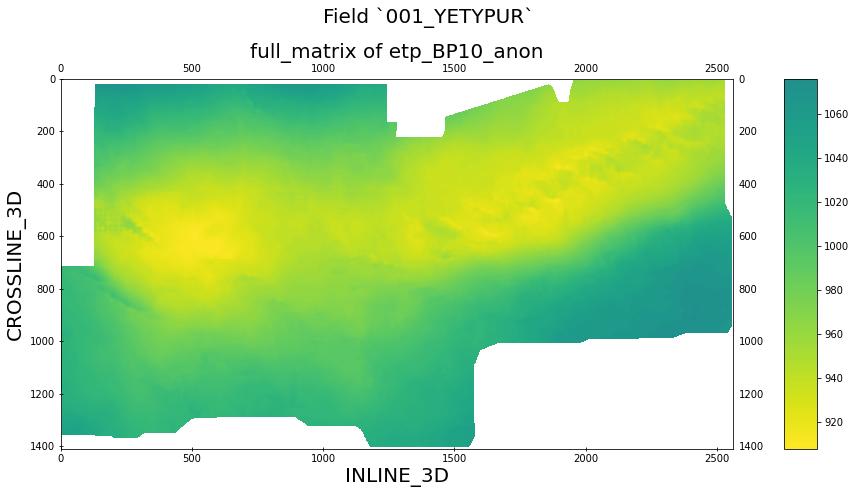

CPU times: user 3.62 s, sys: 719 ms, total: 4.34 s
Wall time: 3.94 s


In [2]:
%%time
field = Field(geometry='/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.qblosc')
horizon = Horizon(storage='~/INPUTS/HORIZONS/FINAL/etp_BP10_anon', field=field)

print(horizon)
horizon.show(scale=FIGURE_SCALE)

After the loading, we can print some key stats on horizon location and its depth.

**Coverage** metric shows the ratio of labeled non-dead traces to all: being more than `1` means that the horizon does not match the geology. Probably, that is an artifact of the auto-picking procedure. We can remove unnecessary labeling with the `filter` method:


Horizon etp_BP10_anon for 001_YETYPUR loaded from file
Ilines range:      0 to 2559
Xlines range:      1 to 1403
Depth range:       908 to 1076
Depth mean:        980.459
Depth std:         43.4773

Length:            2424324
Perimeter:         8242
Coverage:          0.99528
Solidity:          1.0
Num of holes:      0



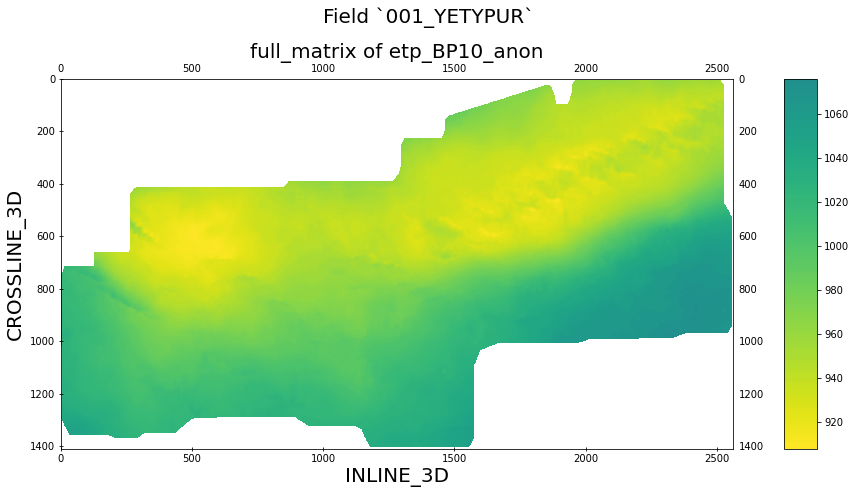

CPU times: user 1.81 s, sys: 456 ms, total: 2.27 s
Wall time: 1.75 s


In [3]:
%%time
horizon.filter()

print(horizon)
horizon.show(scale=FIGURE_SCALE)

The `show` method, used in the previous cells, allows us to look at the depth map of a horizon from above.

Additionally, the `SeismiQB` library has the `show_slide` method for visualization of axial projections (with or without labeling).

CPU times: user 101 ms, sys: 8.61 ms, total: 110 ms
Wall time: 107 ms


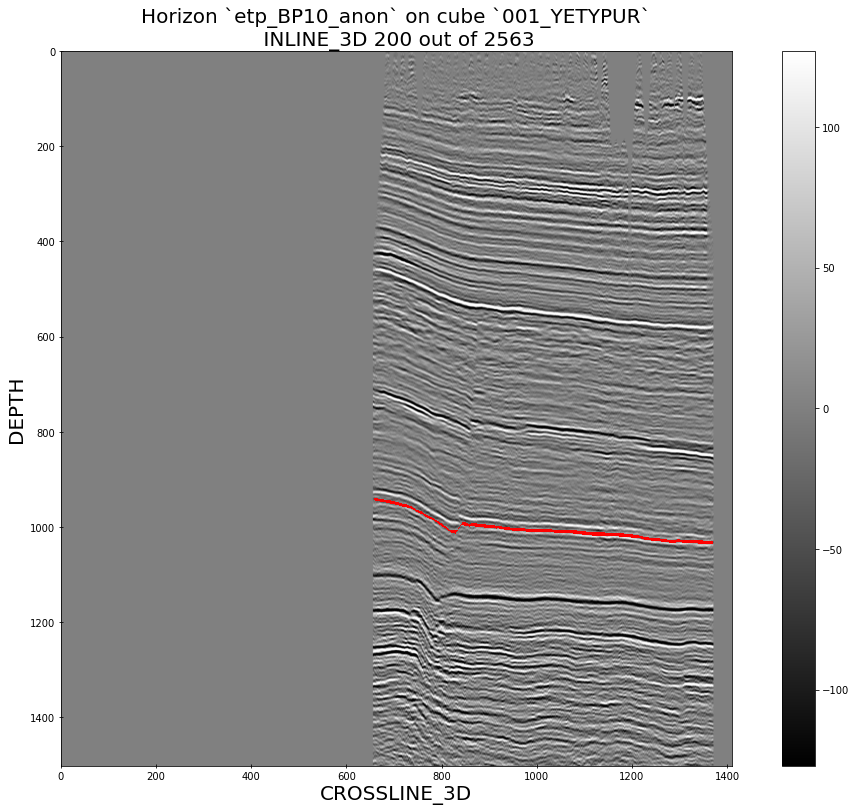

In [4]:
%%time
horizon.show_slide(200, width=10, separate=False, cmap=['gray', 'red'], grid=False, scale=FIGURE_SCALE)

# Horizon representations
<a id='representations'></a>

In `SeismiQB`, each horizon can be represented by multiple underlying storage containers: `points` or/and `matrix`.

- `points` is an array of shape *(N, 3)*, where each row is a point in *(iline, crossline, depth)* format;
- `matrix` is an array of shape *(n_ilines, n_crosslines)*. Essentially, that is a depth map of a horizon.

In [5]:
horizon_points = horizon.points
print("Points representation:\n")
print(horizon.points[:5], '\n')
print("Shape: ", horizon.points.shape)
print("Stored elements:", horizon_points.size)
print(f"Memory: {horizon_points.nbytes/(1024**3):4.2f} GB\n\n")

print("Matrix representation:")
horizon_matrix = horizon.matrix
print("Shape: ", horizon.matrix.shape)
print("Stored elements:", horizon_matrix.size)
print(f"Memory: {horizon_matrix.nbytes/(1024**3):4.2f} GB")

Points representation:

[[   0  737 1020]
 [   0  738 1020]
 [   0  739 1020]
 [   0  740 1020]
 [   0  741 1020]] 

Shape:  (2424324, 3)
Stored elements: 7272972
Memory: 0.03 GB


Matrix representation:
Shape:  (2560, 1403)
Stored elements: 3591680
Memory: 0.01 GB


**The reason to support multiple storages** is simple: speed and efficiency. Some operations can be done faster using the `points` array, while others work better with the `matrix` storage.


**Note** that most of the attributes of `Horizon` instances are loaded **lazily**. If the horizon is initialized from `points`, then the `matrix` attribute is created only at the time of the first access, and same goes for statistics and geological properties. Keeping track of accessed attributes is important when we work with thousands of model-generated horizons, as we want to avoid any unneccessary loadings and cachings.

# Geological attributes and basic data manipulations
<a id='attributes'></a>

We can learn a lot by looking at geological transformations of the horizon depth map and the amplitudes along it. For example, visualizations of transformations can provide information about facies or possible geological fault locations. `SeismiQB` provides a number of pre-defined attributes that can be loaded and displayed by `load_attribute` and `show` methods.

By default, the `show` method displays the depth map of a horizon surface. We can show other geological attributes by using the `src` positional argument:

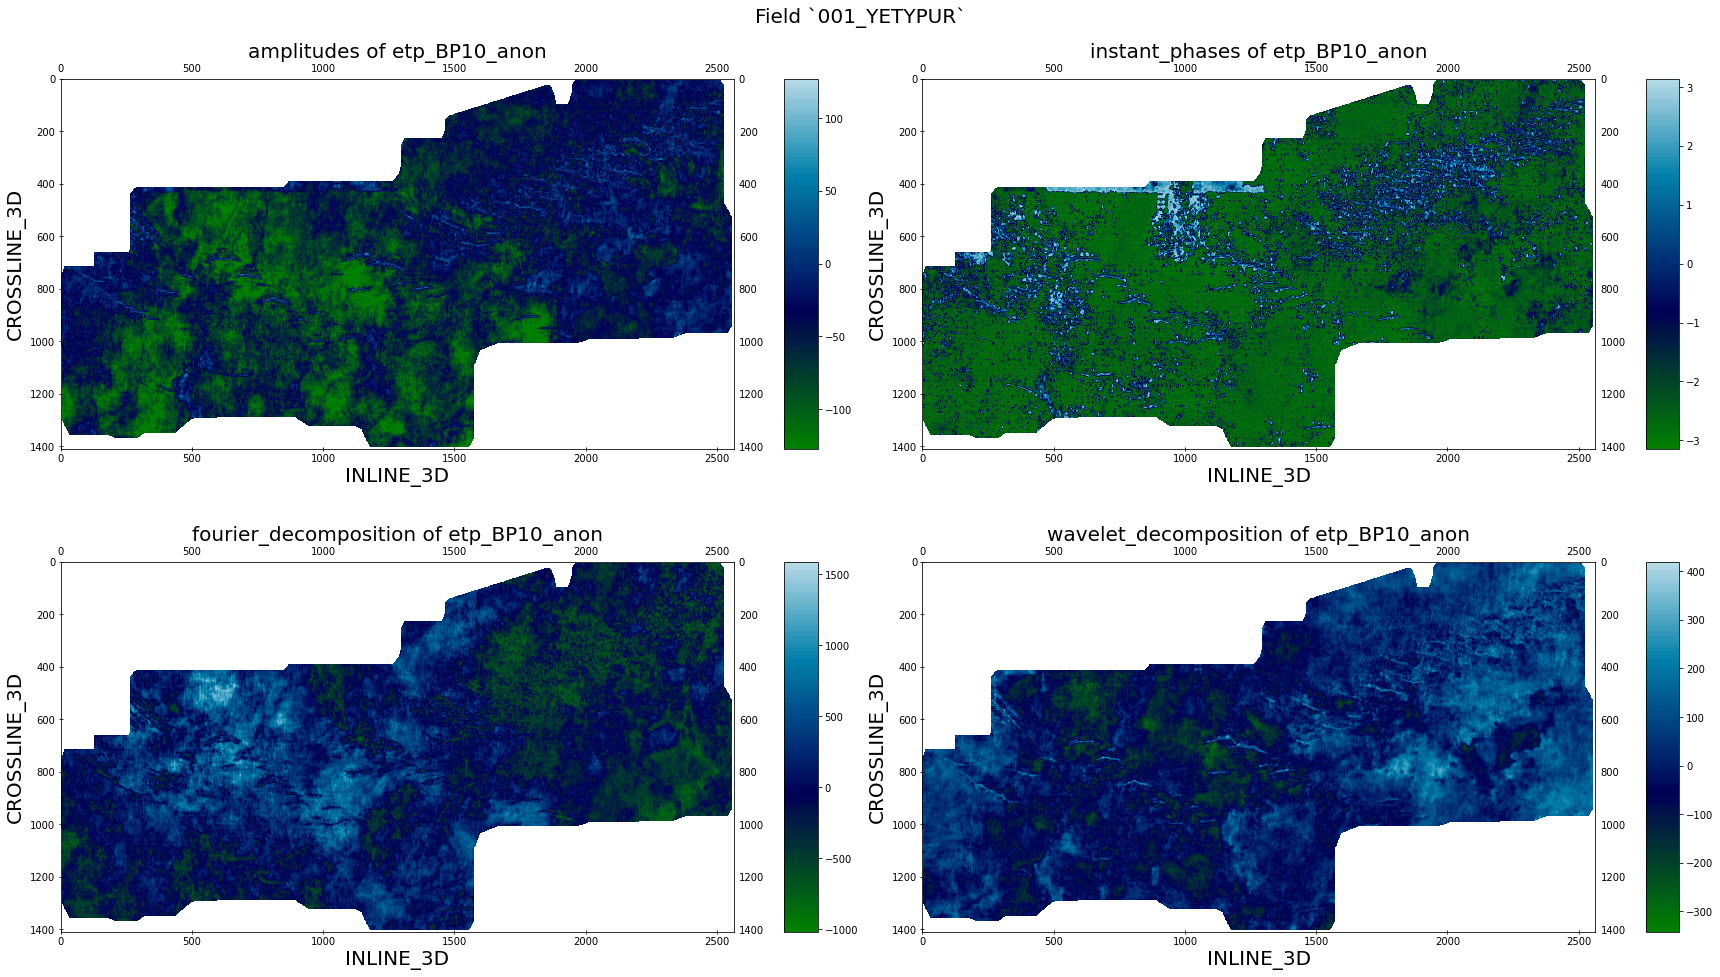

CPU times: user 1min 34s, sys: 2min 7s, total: 3min 41s
Wall time: 1min 3s


In [6]:
%%time
horizon.show(['amplitudes', 'instant_phases', 'fourier_decomposition', 'wavelet_decomposition'],
             ncols=2, nrows=2, separate=True, scale=FIGURE_SCALE)

We also provide a few metric maps of horizon quality: for each trace, we compare the labeling to a set of reference traces. The comparison function can differ: usually, we use the correlation coefficient. The computation of metrics can be speed up by using `gpu` instead of `cpu`.

The `evaluate` method prints several key characteristics and displays a map of support correlation. If traces correlate with supports, then they are green. The closer the color to red, the more complex a region (more it differs from reference traces).


Number of labeled points:                         2424324
Number of points inside borders:                  2424324
Perimeter (length of borders):                    8242
Percentage of labeled non-bad traces:             0.995280439441338
Percentage of labeled traces inside borders:      1.0
Number of holes inside borders:                   0

CPU times: user 6.95 s, sys: 2 s, total: 8.95 s
Wall time: 8.54 s


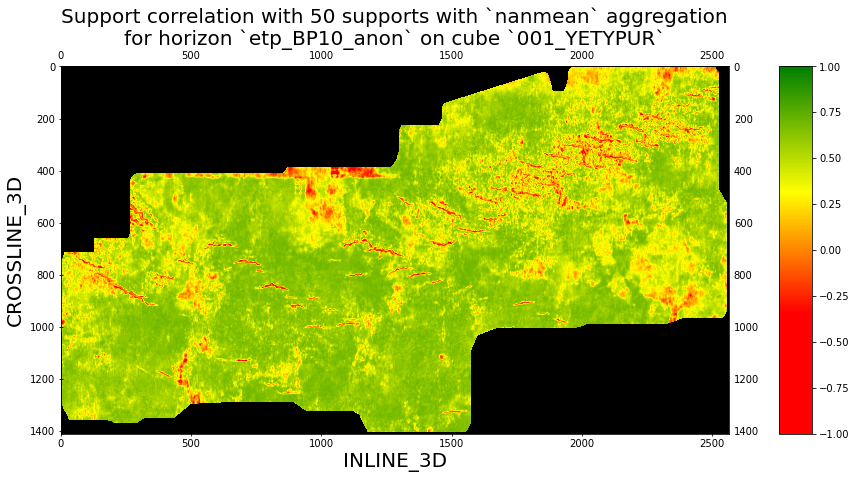

In [7]:
%%time
_ = horizon.evaluate(bad_color='black', device='gpu', scale=FIGURE_SCALE)

To access the amplitude values along the `Horizon`, we use `get_cube_values` method. The `window` is used to change the thickness of extracted data.

Shape of cut subcube: (2563, 1409, 777)
Size of the array: 10.45 GB

Shape of cut subcube: (2563, 777)
Size of the array: 0.01 GB

CPU times: user 1min 45s, sys: 9.82 s, total: 1min 55s
Wall time: 1min 52s


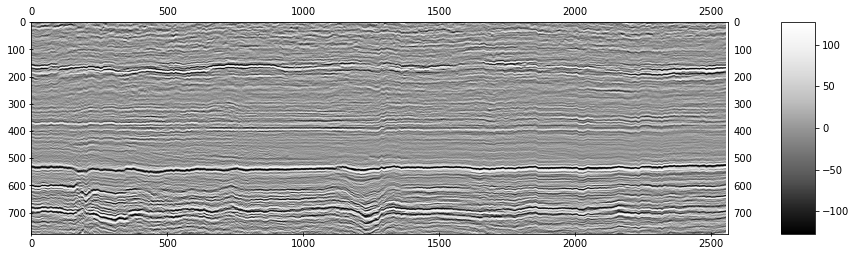

In [8]:
%%time
cut_volume = horizon.get_cube_values(window=777)

print(f'Shape of cut subcube: {cut_volume.shape}')
print(f'Size of the array: {cut_volume.nbytes/(1024**3):4.2f} GB\n')

cut_line = cut_volume[:, 777, :]

print(f'Shape of cut subcube: {cut_line.shape}')
print(f'Size of the array: {cut_line.nbytes/(1024**3):4.2f} GB\n')

plot_image(cut_line, colorbar=True, scale=FIGURE_SCALE)

# Caching
<a id='cache'></a>

In the [geometry tutorial]() we described the caching logic that significantly speeds up the data loading. Here we use the same [LRU cache]() strategy to avoid re-computing of geological attributes. 

Cache API is the same as in the case of `SeismicGeometry`:

In [9]:
# Cache inspectation:
print(f"Cached memory: {horizon.cache_size:4.2f} GB")

print("Cache representation:")
cache_repr = horizon.cache_repr
display(cache_repr)

# Cache nullification:
horizon.reset_cache()

print(f"\nCached memory after reset: {horizon.cache_size:4.2f} GB")
print(f"Cached representation after reset: {horizon.cache_repr}")

Cached memory: 0.74 GB
Cache representation:


,cache_length,cache_size
_presence_matrix,1,0.003363
get_cube_values,1,0.672651
get_fourier_decomposition,1,0.026906
get_instantaneous_phases,1,0.013453
get_wavelet_decomposition,1,0.026906



Cached memory after reset: 0.00 GB
Cached representation after reset: {}


# Additional manipulations
<a id='add_manipulations'></a>

We use neural networks to label the entire horizon starting from a part of its labeling. To validate this technique on real examples, we artificially reduce the coverage of horizon by:

* cutting a sparce carcass from the full horizon
* adding holes to the full horizon

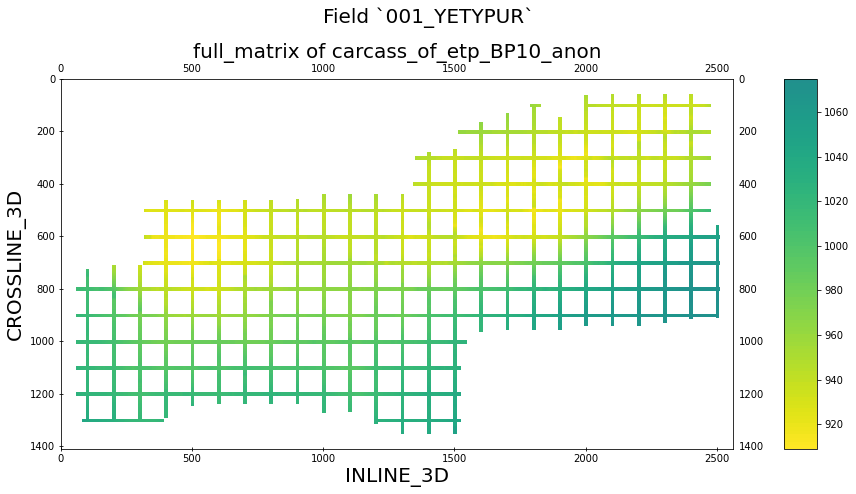

In [10]:
carcass = horizon.make_carcass(frequencies=100, regular=True)
carcass.show(load_kwargs={'enlarge': True, 'enlarge_width': 10}, scale=FIGURE_SCALE)

We use carcasses for training neural networks to extend the full horizon from a sparse grid. In some fields, we want to sample training data in complex areas more often.

For this reason, we create a non-regular grid based on a quality map of the cube: this map evaluates the difficulty of each trace.
A **quality grid** is more frequent in difficult regions. To use it, pass the `regular=False` argument to the `make_carcass` method:

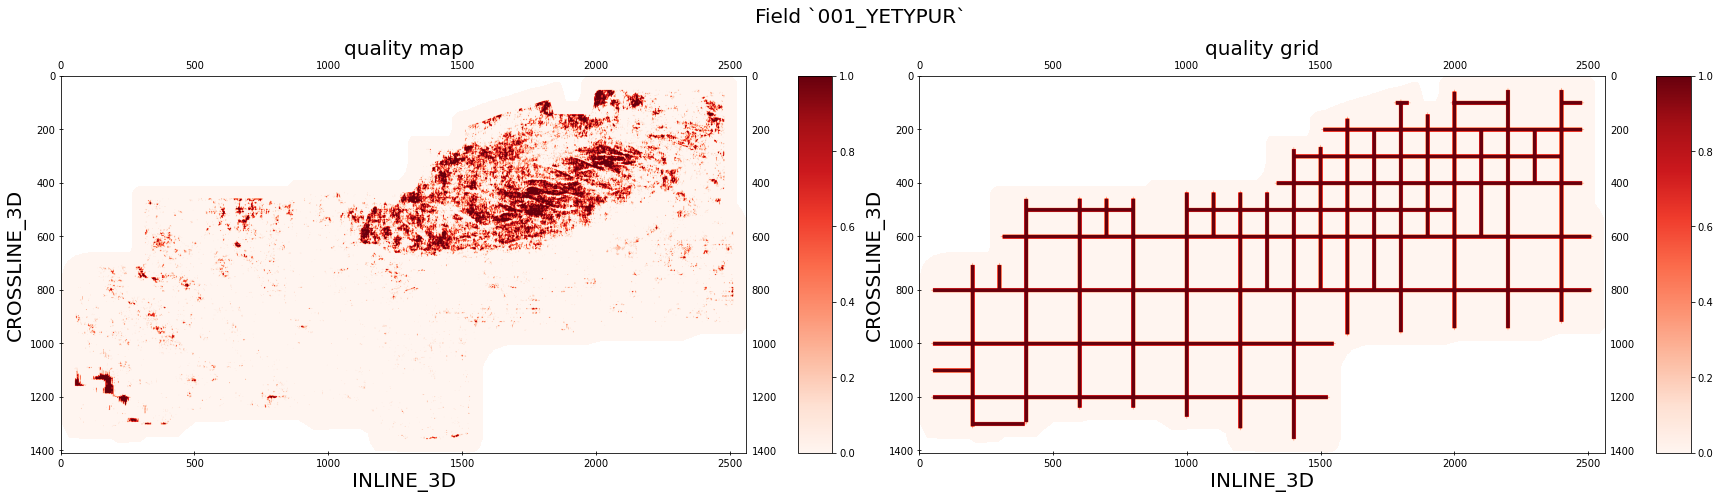

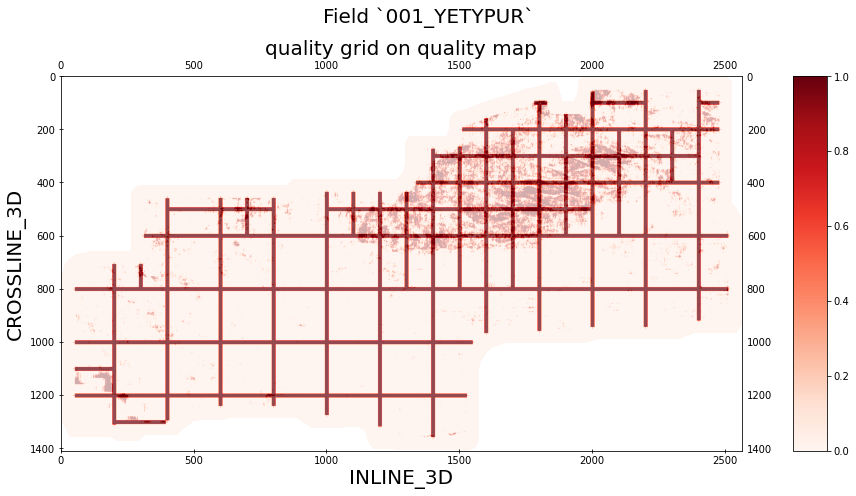

In [11]:
# Create carcass
carcass = horizon.make_carcass(frequencies=(100, 200), regular=False, filter_outliers=100)

carcass_matrix = horizon.matrix_enlarge(carcass.full_binary_matrix, width=7)

field.show(['quality_map', carcass_matrix], cmap='Reds', separate=True, title=['quality map', 'quality grid'], scale=FIGURE_SCALE)
field.show([carcass_matrix, 'quality_map'], cmap='Reds', separate=False, alpha=[1.0, 0.3], title='quality grid on quality map', scale=FIGURE_SCALE)

The next option is to add holes to the horizon surface. It is used to validate the postprocessing procedures of horizon detection.

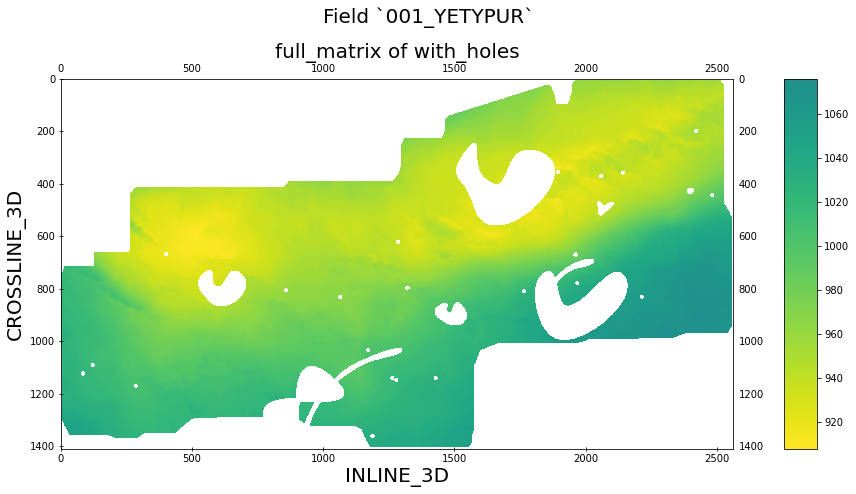

CPU times: user 2.55 s, sys: 448 ms, total: 3 s
Wall time: 2.54 s


In [12]:
%%time
holes_matrix = horizon.make_random_holes_matrix(seed=13)
horizon_with_holes = Horizon(horizon.full_matrix, field=horizon.field, name='with_holes')
horizon_with_holes.filter(holes_matrix)

horizon_with_holes.show(scale=FIGURE_SCALE)

Sometimes model predictions contain sharp discontinuities, which we eliminate using the `despike` method. This helps to make better predictions in these areas.

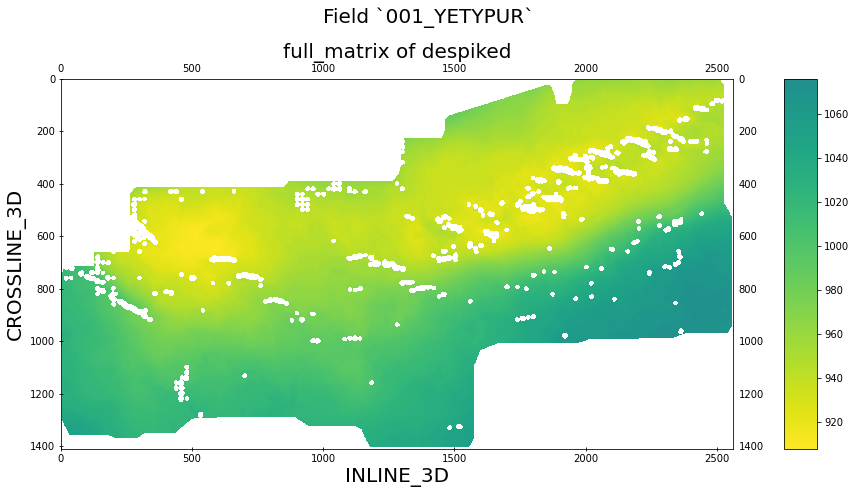

CPU times: user 1.48 s, sys: 398 ms, total: 1.87 s
Wall time: 1.41 s


In [13]:
%%time
horizon_despiked = Horizon(horizon.full_matrix, field=horizon.field, name='despiked')
horizon_despiked.despike()
horizon_despiked.show(scale=FIGURE_SCALE)

# Conclusion

This concludes the `Horizon` tutorial. To sum up, you have learned how to:

- load, inspect and visualize horizons by computing key characteristics (coverage, amount of labeled and non-labeled traces, etc.) and geological attributes (amplitudes, phases, decompositions)
- apply useful manipulations to horizons as cutting carcasses, holes, and sharp discontinuities
- cache computed attributes for saving time on repeated actions

In [the next one](./03_Cubeset.ipynb), you will learn how to work with an entire dataset of seismic cubes and horizons!